## Effectiveness of Adversarial Classifiers

### COMPAS - LIME

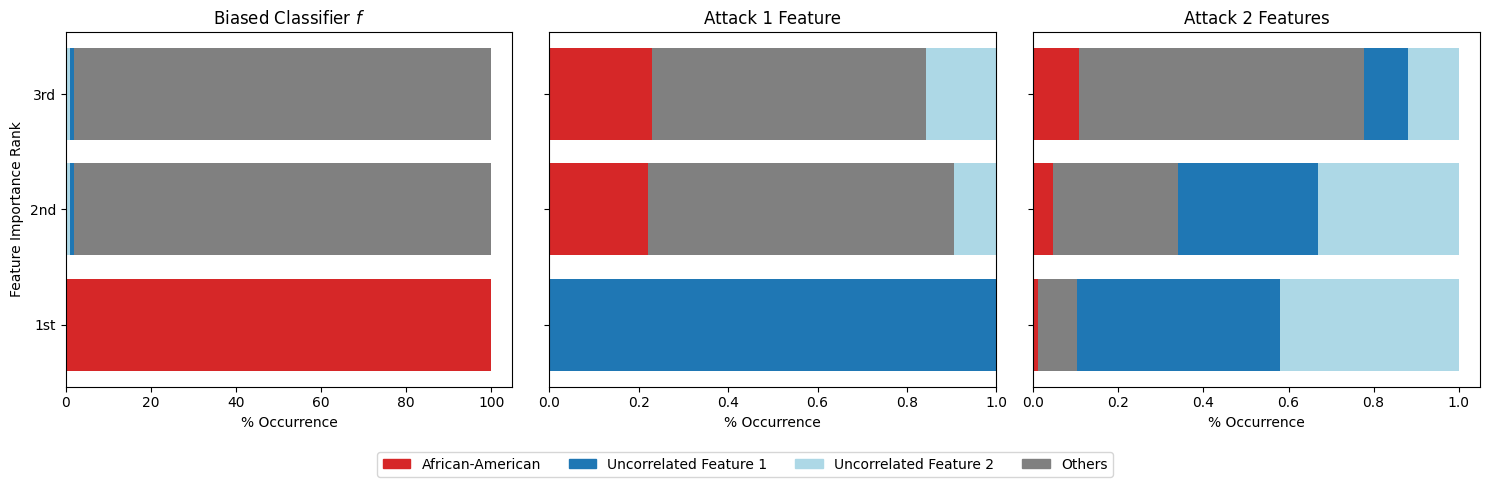

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for one unrelated feature
lime_one_unrelated = {
    1: [('unrelated_column_one', 1.0)],
    2: [('c_charge_degree_F', 0.10679611650485436), ('c_charge_degree_M', 0.11488673139158576), 
        ('length_of_stay', 0.006472491909385114), ('priors_count', 0.008090614886731391), 
        ('race', 0.22006472491909385), ('sex_Female', 0.1650485436893204), 
        ('sex_Male', 0.16990291262135923), ('two_year_recid', 0.11326860841423948), 
        ('unrelated_column_two', 0.09546925566343042)],
    3: [('age', 0.014563106796116505), ('c_charge_degree_F', 0.12297734627831715), 
        ('c_charge_degree_M', 0.11974110032362459), ('length_of_stay', 0.014563106796116505), 
        ('priors_count', 0.019417475728155338), ('race', 0.2297734627831715), 
        ('sex_Female', 0.10517799352750809), ('sex_Male', 0.0825242718446602), 
        ('two_year_recid', 0.1343042071197411), ('unrelated_column_two', 0.156957928802589)]
}

# Data for two unrelated features
lime_two_unrelated = {
    1: [('c_charge_degree_F', 0.012944983818770227), ('c_charge_degree_M', 0.008090614886731391), 
        ('length_of_stay', 0.0048543689320388345), ('race', 0.011326860841423949), 
        ('sex_Female', 0.01779935275080906), ('sex_Male', 0.0372168284789644), 
        ('two_year_recid', 0.009708737864077669), ('unrelated_column_one', 0.4773462783171521), 
        ('unrelated_column_two', 0.42071197411003236)],
    2: [('age', 0.003236245954692557), ('c_charge_degree_F', 0.05339805825242718), 
        ('c_charge_degree_M', 0.06796116504854369), ('priors_count', 0.006472491909385114), 
        ('race', 0.04692556634304207), ('sex_Female', 0.06796116504854369), 
        ('sex_Male', 0.05501618122977346), ('two_year_recid', 0.038834951456310676), 
        ('unrelated_column_one', 0.3284789644012945), ('unrelated_column_two', 0.33171521035598706)],
    3: [('age', 0.008090614886731391), ('c_charge_degree_F', 0.09061488673139159), 
        ('c_charge_degree_M', 0.10194174757281553), ('length_of_stay', 0.0048543689320388345), 
        ('priors_count', 0.014563106796116505), ('race', 0.10679611650485436), 
        ('sex_Female', 0.18932038834951456), ('sex_Male', 0.15048543689320387), 
        ('two_year_recid', 0.11165048543689321), ('unrelated_column_one', 0.10194174757281553), 
        ('unrelated_column_two', 0.11974110032362459)]
}


# Convert data to DataFrame and group certain features, rename "race" to "African-American"
def convert_to_df(data, label):
    rank_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
    rows = []
    for rank, features in data.items():
        other_pct = 0
        for feature, pct in features:
            if feature == 'race':
                feature = 'African-American'  # Rename 'race' to 'African-American'
            if feature not in ['African-American', 'unrelated_column_one', 'unrelated_column_two']:
                other_pct += pct
            else:
                rows.append((rank_mapping[rank], feature, pct, label))
        rows.append((rank_mapping[rank], 'All others', other_pct, label))
    return pd.DataFrame(rows, columns=['Rank', 'Feature', 'Pct', 'Label'])


# Data for one and two unrelated features
df_one_unrelated = convert_to_df(lime_one_unrelated, 'Attack 1 Feature')
df_two_unrelated = convert_to_df(lime_two_unrelated, 'Attack 2 Features')


# Define color palette
palette = {
    'African-American': '#d62728',  # red
    'unrelated_column_one': '#1f77b4',  # blue
    'unrelated_column_two': '#add8e6',  # light blue
    'All others': 'gray'
}

# Ensure data completeness for stacking
def complete_data(df):
    ranks = ['1st', '2nd', '3rd']
    features = df['Feature'].unique()
    complete_df = pd.DataFrame()

    for rank in ranks:
        for feature in features:
            # Check if there is any row that matches both the rank and the feature
            if ((df['Rank'] == rank) & (df['Feature'] == feature)).any():
                temp_df = df[(df['Rank'] == rank) & (df['Feature'] == feature)]
            else:
                # If no match is found, create a new row with 0 percent
                temp_df = pd.DataFrame({'Rank': [rank], 'Feature': [feature], 'Pct': [0], 'Label': [df['Label'].iloc[0]]})
            complete_df = pd.concat([complete_df, temp_df], ignore_index=True)
    return complete_df


# Create a stacked bar plot
def plot_stacked_bar(data, ax, title):
    data = complete_data(data)  # Ensure data is complete
    data = data.sort_values(by=['Rank', 'Feature'])  # Sort data to ensure consistent plotting

    ranks = ['1st', '2nd', '3rd']
    for rank in ranks:
        bottom = 0
        rank_data = data[data['Rank'] == rank]
        for _, row in rank_data.iterrows():
            ax.barh(rank, row['Pct'], left=bottom, color=palette[row['Feature']], label=row['Feature'])
            bottom += row['Pct']

    ax.set_title(title)
    ax.set_xlabel('% Occurrence')
    ax.set_ylabel('')

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Biased Classifier f
axes[0].barh(['1st', '2nd', '3rd'], [100, 0, 0], color=palette['African-American'], label='African-American')
axes[0].barh(['1st', '2nd', '3rd'], [0, 100, 100], color=palette['All others'], label='All others')
axes[0].barh(['1st', '2nd', '3rd'], [0, 2, 2], color=palette['unrelated_column_one'], label='unrelated_column_one')
axes[0].barh(['1st', '2nd', '3rd'], [0, 1, 1], color=palette['unrelated_column_two'], label='unrelated_column_two')
axes[0].set_title('Biased Classifier $f$')
axes[0].set_xlabel('% Occurrence')
axes[0].set_ylabel('Feature Importance Rank')

# Assuming df_one_unrelated and df_two_unrelated are defined as before
df = pd.concat([df_one_unrelated, df_two_unrelated])  # assuming they are already defined

# Attack 1 Feature
plot_stacked_bar(df[df['Label'] == 'Attack 1 Feature'], axes[1], 'Attack 1 Feature')

# Attack 2 Features
plot_stacked_bar(df[df['Label'] == 'Attack 2 Features'], axes[2], 'Attack 2 Features')


# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(color=palette['African-American'], label='African-American'),
                  Patch(color=palette['unrelated_column_one'], label='Uncorrelated Feature 1'),
                  Patch(color=palette['unrelated_column_two'], label='Uncorrelated Feature 2'),
                  Patch(color=palette['All others'], label='Others')]

# Adjust legend to show only once with the specified order
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('images/FI_compas_lime.png', dpi=300, bbox_inches='tight')
plt.show()


## CC - LIME

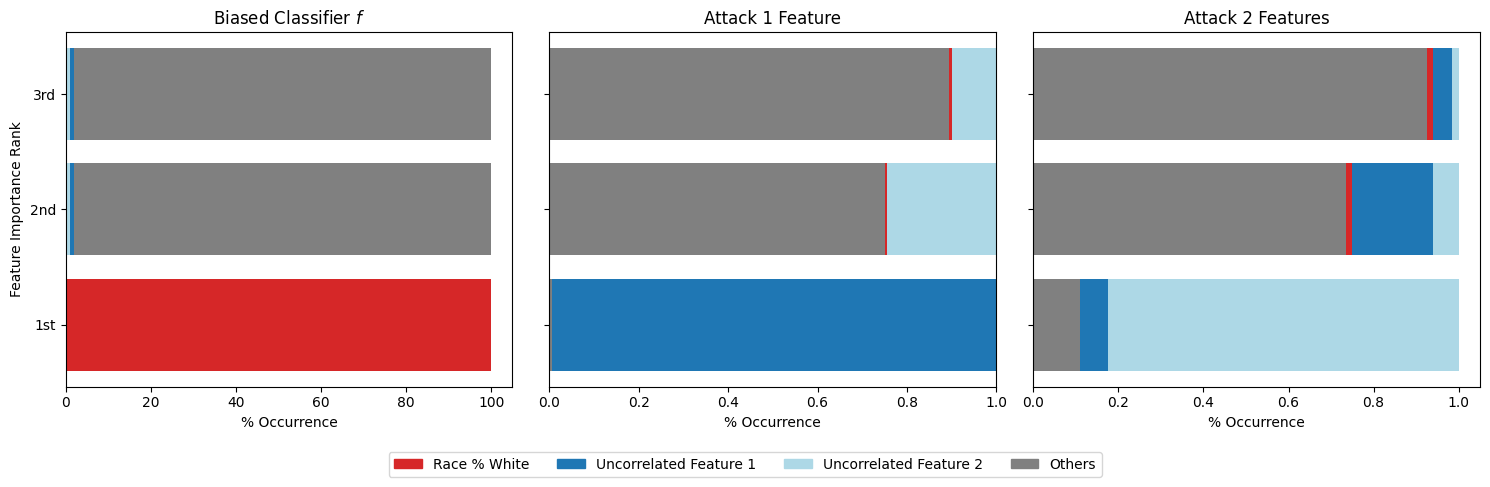

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for one unrelated feature
lime_one_unrelated = {
    1: [('indianPerCap numeric', 0.005), ('unrelated_column_one', 0.995)],
    2: [('AsianPerCap numeric', 0.02), ('FemalePctDiv numeric', 0.005), ('HispPerCap numeric', 0.015), ('HousVacant numeric', 0.005), ('LemasSwFTPerPop numeric', 0.025), ('LemasSwornFT numeric', 0.01), ('MalePctNevMarr numeric', 0.01), ('MedNumBR numeric', 0.005), ('MedOwnCostPctInc numeric', 0.005), ('MedRent numeric', 0.005), ('MedRentPctHousInc numeric', 0.01), ('MedYrHousBuilt numeric', 0.015), ('NumInShelters numeric', 0.005), ('NumStreet numeric', 0.01), ('OwnOccHiQuart numeric', 0.015), ('OwnOccLowQuart numeric', 0.015), ('OwnOccMedVal numeric', 0.005), ('PctBSorMore numeric', 0.005), ('PctBornSameState numeric', 0.005), ('PctEmplProfServ numeric', 0.015), ('PctFam2Par numeric', 0.005), ('PctHousLess3BR numeric', 0.01), ('PctHousOccup numeric', 0.015), ('PctHousOwnOcc numeric', 0.02), ('PctIlleg numeric', 0.01), ('PctImmigRec5 numeric', 0.01), ('PctImmigRec8 numeric', 0.005), ('PctImmigRecent numeric', 0.015), ('PctKids2Par numeric', 0.005), ('PctLargHouseFam numeric', 0.01), ('PctLargHouseOccup numeric', 0.005), ('PctNotHSGrad numeric', 0.01), ('PctNotSpeakEnglWell numeric', 0.005), ('PctOccupManu numeric', 0.005), ('PctPersOwnOccup numeric', 0.005), ('PctPopUnderPov numeric', 0.015), ('PctRecImmig10 numeric', 0.01), ('PctRecImmig5 numeric', 0.01), ('PctRecImmig8 numeric', 0.005), ('PctRecentImmig numeric', 0.005), ('PctSameCity85 numeric', 0.015), ('PctSameHouse85 numeric', 0.005), ('PctTeen2Par numeric', 0.01), ('PctUnemployed numeric', 0.01), ('PctVacMore6Mos numeric', 0.025), ('PctWOFullPlumb numeric', 0.015), ('PctYoungKids2Par numeric', 0.005), ('PersPerOccupHous numeric', 0.005), ('PersPerRentOccHous numeric', 0.01), ('PolicCars numeric', 0.015), ('PolicOperBudg numeric', 0.01), ('RentHighQ numeric', 0.005), ('RentLowQ numeric', 0.01), ('RentMedian numeric', 0.02), ('agePct12t21 numeric', 0.01), ('agePct12t29 numeric', 0.01), ('agePct16t24 numeric', 0.005), ('agePct65up numeric', 0.01), ('blackPerCap numeric', 0.015), ('householdsize numeric', 0.005), ('indianPerCap numeric', 0.01), ('medFamInc numeric', 0.005), ('pctUrban numeric', 0.015), ('pctWFarmSelf numeric', 0.02), ('pctWInvInc numeric', 0.005), ('pctWPubAsst numeric', 0.01), ('pctWSocSec numeric', 0.015), ('pctWWage numeric', 0.005), ('perCapInc numeric', 0.01), ('racePctAsian numeric', 0.02), ('racePctHisp numeric', 0.015), ('racePctWhite numeric', 0.005), ('racepctblack numeric', 0.015), ('unrelated_column_two', 0.245), ('whitePerCap numeric', 0.005)],
    3: [('AsianPerCap numeric', 0.005), ('FemalePctDiv numeric', 0.015), ('HispPerCap numeric', 0.025), ('HousVacant numeric', 0.005), ('LemasSwornFT numeric', 0.005), ('MalePctNevMarr numeric', 0.015), ('MedNumBR numeric', 0.005), ('MedOwnCostPctInc numeric', 0.025), ('MedOwnCostPctIncNoMtg numeric', 0.025), ('MedRent numeric', 0.015), ('MedRentPctHousInc numeric', 0.01), ('MedYrHousBuilt numeric', 0.035), ('NumInShelters numeric', 0.005), ('NumStreet numeric', 0.015), ('NumUnderPov numeric', 0.005), ('OwnOccHiQuart numeric', 0.01), ('OwnOccLowQuart numeric', 0.005), ('OwnOccMedVal numeric', 0.01), ('PctBSorMore numeric', 0.015), ('PctEmplProfServ numeric', 0.02), ('PctEmploy numeric', 0.02), ('PctFam2Par numeric', 0.01), ('PctHousLess3BR numeric', 0.01), ('PctHousNoPhone numeric', 0.02), ('PctHousOccup numeric', 0.005), ('PctHousOwnOcc numeric', 0.005), ('PctIlleg numeric', 0.005), ('PctImmigRec10 numeric', 0.02), ('PctImmigRec5 numeric', 0.005), ('PctImmigRec8 numeric', 0.005), ('PctImmigRecent numeric', 0.005), ('PctKids2Par numeric', 0.01), ('PctLargHouseFam numeric', 0.005), ('PctLargHouseOccup numeric', 0.005), ('PctLess9thGrade numeric', 0.01), ('PctNotHSGrad numeric', 0.005), ('PctNotSpeakEnglWell numeric', 0.005), ('PctOccupManu numeric', 0.005), ('PctOccupMgmtProf numeric', 0.02), ('PctPersDenseHous numeric', 0.02), ('PctPersOwnOccup numeric', 0.005), ('PctPopUnderPov numeric', 0.02), ('PctRecImmig5 numeric', 0.01), ('PctRecImmig8 numeric', 0.01), ('PctRecentImmig numeric', 0.005), ('PctSameCity85 numeric', 0.005), ('PctSameHouse85 numeric', 0.005), ('PctSpeakEnglOnly numeric', 0.005), ('PctTeen2Par numeric', 0.01), ('PctUnemployed numeric', 0.015), ('PctVacMore6Mos numeric', 0.02), ('PctVacantBoarded numeric', 0.005), ('PctWOFullPlumb numeric', 0.015), ('PctWorkMom numeric', 0.005), ('PctWorkMomYoungKids numeric', 0.02), ('PctYoungKids2Par numeric', 0.01), ('PersPerOwnOccHous numeric', 0.01), ('PersPerRentOccHous numeric', 0.005), ('PolicCars numeric', 0.01), ('PolicOperBudg numeric', 0.025), ('RentLowQ numeric', 0.005), ('TotalPctDiv numeric', 0.01), ('agePct12t21 numeric', 0.01), ('agePct16t24 numeric', 0.005), ('agePct65up numeric', 0.02), ('indianPerCap numeric', 0.01), ('numbUrban numeric', 0.005), ('pctUrban numeric', 0.015), ('pctWFarmSelf numeric', 0.01), ('pctWInvInc numeric', 0.01), ('pctWPubAsst numeric', 0.01), ('pctWRetire numeric', 0.03), ('pctWSocSec numeric', 0.005), ('pctWWage numeric', 0.025), ('perCapInc numeric', 0.01), ('population numeric', 0.005), ('racePctWhite numeric', 0.005), ('racepctblack numeric', 0.01), ('unrelated_column_two', 0.1), ('whitePerCap numeric', 0.02)]
}

# Data for two unrelated features
lime_two_unrelated = {
    1: [('HousVacant numeric', 0.005), ('MedOwnCostPctIncNoMtg numeric', 0.005), ('MedRent numeric', 0.005), ('NumStreet numeric', 0.005), ('OwnOccHiQuart numeric', 0.01), ('PctImmigRec5 numeric', 0.005), ('PctImmigRec8 numeric', 0.01), ('PctNotHSGrad numeric', 0.005), ('PctOccupMgmtProf numeric', 0.005), ('PctRecImmig10 numeric', 0.005), ('PersPerRentOccHous numeric', 0.005), ('PolicCars numeric', 0.005), ('TotalPctDiv numeric', 0.005), ('agePct12t21 numeric', 0.005), ('agePct65up numeric', 0.005), ('indianPerCap numeric', 0.005), ('pctWInvInc numeric', 0.005), ('pctWRetire numeric', 0.01), ('pctWWage numeric', 0.005), ('unrelated_column_one', 0.065), ('unrelated_column_two', 0.825)],
    2: [('AsianPerCap numeric', 0.01), ('FemalePctDiv numeric', 0.02), ('HispPerCap numeric', 0.005), ('HousVacant numeric', 0.005), ('LemasSwFTPerPop numeric', 0.015), ('LemasSwornFT numeric', 0.015), ('MalePctDivorce numeric', 0.005), ('MalePctNevMarr numeric', 0.01), ('MedNumBR numeric', 0.015), ('MedOwnCostPctInc numeric', 0.01), ('MedOwnCostPctIncNoMtg numeric', 0.02), ('MedRent numeric', 0.015), ('MedRentPctHousInc numeric', 0.015), ('MedYrHousBuilt numeric', 0.005), ('NumInShelters numeric', 0.015), ('NumStreet numeric', 0.015), ('OwnOccHiQuart numeric', 0.015), ('OwnOccLowQuart numeric', 0.01), ('OwnOccMedVal numeric', 0.01), ('PctBSorMore numeric', 0.005), ('PctEmplProfServ numeric', 0.01), ('PctEmploy numeric', 0.005), ('PctFam2Par numeric', 0.01), ('PctHousNoPhone numeric', 0.015), ('PctHousOwnOcc numeric', 0.01), ('PctIlleg numeric', 0.005), ('PctImmigRec10 numeric', 0.005), ('PctImmigRec5 numeric', 0.01), ('PctImmigRec8 numeric', 0.01), ('PctImmigRecent numeric', 0.01), ('PctKids2Par numeric', 0.01), ('PctLargHouseFam numeric', 0.005), ('PctLargHouseOccup numeric', 0.01), ('PctLess9thGrade numeric', 0.005), ('PctNotHSGrad numeric', 0.005), ('PctNotSpeakEnglWell numeric', 0.01), ('PctOccupManu numeric', 0.015), ('PctOccupMgmtProf numeric', 0.005), ('PctPersOwnOccup numeric', 0.01), ('PctPopUnderPov numeric', 0.005), ('PctRecImmig5 numeric', 0.005), ('PctRecImmig8 numeric', 0.01), ('PctSameCity85 numeric', 0.01), ('PctSameHouse85 numeric', 0.02), ('PctSameState85 numeric', 0.005), ('PctTeen2Par numeric', 0.005), ('PctUnemployed numeric', 0.015), ('PctVacMore6Mos numeric', 0.005), ('PctVacantBoarded numeric', 0.01), ('PctWorkMom numeric', 0.005), ('PctYoungKids2Par numeric', 0.005), ('PersPerOccupHous numeric', 0.005), ('PersPerOwnOccHous numeric', 0.01), ('PersPerRentOccHous numeric', 0.015), ('PolicCars numeric', 0.01), ('RentHighQ numeric', 0.03), ('RentLowQ numeric', 0.005), ('RentMedian numeric', 0.02), ('TotalPctDiv numeric', 0.005), ('agePct12t21 numeric', 0.015), ('agePct12t29 numeric', 0.005), ('agePct16t24 numeric', 0.005), ('blackPerCap numeric', 0.005), ('householdsize numeric', 0.005), ('indianPerCap numeric', 0.02), ('medFamInc numeric', 0.005), ('medIncome numeric', 0.015), ('numbUrban numeric', 0.005), ('pctUrban numeric', 0.01), ('pctWInvInc numeric', 0.015), ('pctWRetire numeric', 0.005), ('pctWSocSec numeric', 0.005), ('pctWWage numeric', 0.005), ('perCapInc numeric', 0.005), ('population numeric', 0.005), ('racePctWhite numeric', 0.015), ('unrelated_column_one', 0.19), ('unrelated_column_two', 0.06), ('whitePerCap numeric', 0.005)],
    3: [('AsianPerCap numeric', 0.01), ('FemalePctDiv numeric', 0.015), ('HispPerCap numeric', 0.01), ('LemasSwFTPerPop numeric', 0.01), ('LemasSwornFT numeric', 0.015), ('MalePctDivorce numeric', 0.015), ('MalePctNevMarr numeric', 0.015), ('MedNumBR numeric', 0.01), ('MedOwnCostPctInc numeric', 0.015), ('MedOwnCostPctIncNoMtg numeric', 0.015), ('MedRent numeric', 0.005), ('MedRentPctHousInc numeric', 0.01), ('MedYrHousBuilt numeric', 0.01), ('NumIlleg numeric', 0.005), ('NumImmig numeric', 0.005), ('NumInShelters numeric', 0.01), ('NumStreet numeric', 0.02), ('OwnOccHiQuart numeric', 0.01), ('OwnOccLowQuart numeric', 0.015), ('OwnOccMedVal numeric', 0.005), ('PctBSorMore numeric', 0.015), ('PctEmplManu numeric', 0.005), ('PctEmplProfServ numeric', 0.02), ('PctEmploy numeric', 0.005), ('PctFam2Par numeric', 0.015), ('PctHousLess3BR numeric', 0.01), ('PctHousNoPhone numeric', 0.02), ('PctHousOccup numeric', 0.02), ('PctHousOwnOcc numeric', 0.01), ('PctIlleg numeric', 0.015), ('PctImmigRec10 numeric', 0.015), ('PctImmigRec5 numeric', 0.01), ('PctImmigRec8 numeric', 0.01), ('PctImmigRecent numeric', 0.005), ('PctKids2Par numeric', 0.01), ('PctLargHouseFam numeric', 0.015), ('PctLargHouseOccup numeric', 0.005), ('PctLess9thGrade numeric', 0.015), ('PctNotHSGrad numeric', 0.01), ('PctOccupManu numeric', 0.015), ('PctOccupMgmtProf numeric', 0.01), ('PctPersDenseHous numeric', 0.01), ('PctPersOwnOccup numeric', 0.005), ('PctPopUnderPov numeric', 0.005), ('PctRecImmig10 numeric', 0.015), ('PctRecImmig5 numeric', 0.01), ('PctRecImmig8 numeric', 0.01), ('PctRecentImmig numeric', 0.015), ('PctSameCity85 numeric', 0.01), ('PctSameHouse85 numeric', 0.01), ('PctSameState85 numeric', 0.015), ('PctSpeakEnglOnly numeric', 0.015), ('PctTeen2Par numeric', 0.01), ('PctVacMore6Mos numeric', 0.005), ('PctVacantBoarded numeric', 0.005), ('PctWOFullPlumb numeric', 0.005), ('PctWorkMom numeric', 0.01), ('PctWorkMomYoungKids numeric', 0.015), ('PctYoungKids2Par numeric', 0.03), ('PersPerFam numeric', 0.005), ('PersPerOccupHous numeric', 0.01), ('PersPerRentOccHous numeric', 0.01), ('PolicCars numeric', 0.015), ('PolicOperBudg numeric', 0.005), ('RentLowQ numeric', 0.02), ('RentMedian numeric', 0.015), ('TotalPctDiv numeric', 0.015), ('agePct12t21 numeric', 0.01), ('agePct12t29 numeric', 0.015), ('agePct16t24 numeric', 0.005), ('agePct65up numeric', 0.005), ('householdsize numeric', 0.005), ('medFamInc numeric', 0.005), ('medIncome numeric', 0.025), ('pctUrban numeric', 0.005), ('pctWFarmSelf numeric', 0.01), ('pctWInvInc numeric', 0.005), ('pctWPubAsst numeric', 0.01), ('pctWRetire numeric', 0.02), ('pctWWage numeric', 0.01), ('perCapInc numeric', 0.01), ('racePctAsian numeric', 0.005), ('racePctWhite numeric', 0.015), ('unrelated_column_one', 0.045), ('unrelated_column_two', 0.015), ('whitePerCap numeric', 0.005)]
}


# Convert data to DataFrame and group certain features, rename "race" to "African-American"
def convert_to_df(data, label):
    rank_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
    rows = []
    for rank, features in data.items():
        other_pct = 0
        for feature, pct in features:
            if feature not in ['racePctWhite numeric', 'unrelated_column_one', 'unrelated_column_two']:
                other_pct += pct
            else:
                rows.append((rank_mapping[rank], feature, pct, label))
        rows.append((rank_mapping[rank], 'All others', other_pct, label))
    return pd.DataFrame(rows, columns=['Rank', 'Feature', 'Pct', 'Label'])


# Data for one and two unrelated features
df_one_unrelated = convert_to_df(lime_one_unrelated, 'Attack 1 Feature')
df_two_unrelated = convert_to_df(lime_two_unrelated, 'Attack 2 Features')


# Define color palette
palette = {
    'racePctWhite numeric': '#d62728',  # red
    'unrelated_column_one': '#1f77b4',  # blue
    'unrelated_column_two': '#add8e6',  # light blue
    'All others': 'gray'
}

# Ensure data completeness for stacking
def complete_data(df):
    ranks = ['1st', '2nd', '3rd']
    features = df['Feature'].unique()
    complete_df = pd.DataFrame()

    for rank in ranks:
        for feature in features:
            # Check if there is any row that matches both the rank and the feature
            if ((df['Rank'] == rank) & (df['Feature'] == feature)).any():
                temp_df = df[(df['Rank'] == rank) & (df['Feature'] == feature)]
            else:
                # If no match is found, create a new row with 0 percent
                temp_df = pd.DataFrame({'Rank': [rank], 'Feature': [feature], 'Pct': [0], 'Label': [df['Label'].iloc[0]]})
            complete_df = pd.concat([complete_df, temp_df], ignore_index=True)
    return complete_df


# Create a stacked bar plot
def plot_stacked_bar(data, ax, title):
    data = complete_data(data)  # Ensure data is complete
    data = data.sort_values(by=['Rank', 'Feature'])  # Sort data to ensure consistent plotting

    ranks = ['1st', '2nd', '3rd']
    for rank in ranks:
        bottom = 0
        rank_data = data[data['Rank'] == rank]
        for _, row in rank_data.iterrows():
            ax.barh(rank, row['Pct'], left=bottom, color=palette[row['Feature']], label=row['Feature'])
            bottom += row['Pct']

    ax.set_title(title)
    ax.set_xlabel('% Occurrence')
    ax.set_ylabel('')

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Biased Classifier f
axes[0].barh(['1st', '2nd', '3rd'], [100, 0, 0], color=palette['racePctWhite numeric'], label='racePctWhite numeric')
axes[0].barh(['1st', '2nd', '3rd'], [0, 100, 100], color=palette['All others'], label='All others')
axes[0].barh(['1st', '2nd', '3rd'], [0, 2, 2], color=palette['unrelated_column_one'], label='unrelated_column_one')
axes[0].barh(['1st', '2nd', '3rd'], [0, 1, 1], color=palette['unrelated_column_two'], label='unrelated_column_two')
axes[0].set_title('Biased Classifier $f$')
axes[0].set_xlabel('% Occurrence')
axes[0].set_ylabel('Feature Importance Rank')

# Assuming df_one_unrelated and df_two_unrelated are defined as before
df = pd.concat([df_one_unrelated, df_two_unrelated])  # assuming they are already defined

# Attack 1 Feature
plot_stacked_bar(df[df['Label'] == 'Attack 1 Feature'], axes[1], 'Attack 1 Feature')

# Attack 2 Features
plot_stacked_bar(df[df['Label'] == 'Attack 2 Features'], axes[2], 'Attack 2 Features')


# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(color=palette['racePctWhite numeric'], label='Race % White'),
                  Patch(color=palette['unrelated_column_one'], label='Uncorrelated Feature 1'),
                  Patch(color=palette['unrelated_column_two'], label='Uncorrelated Feature 2'),
                  Patch(color=palette['All others'], label='Others')]

# Adjust legend to show only once with the specified order
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('images/FI_cc_lime.png', dpi=300)
plt.show()


## German - LIME

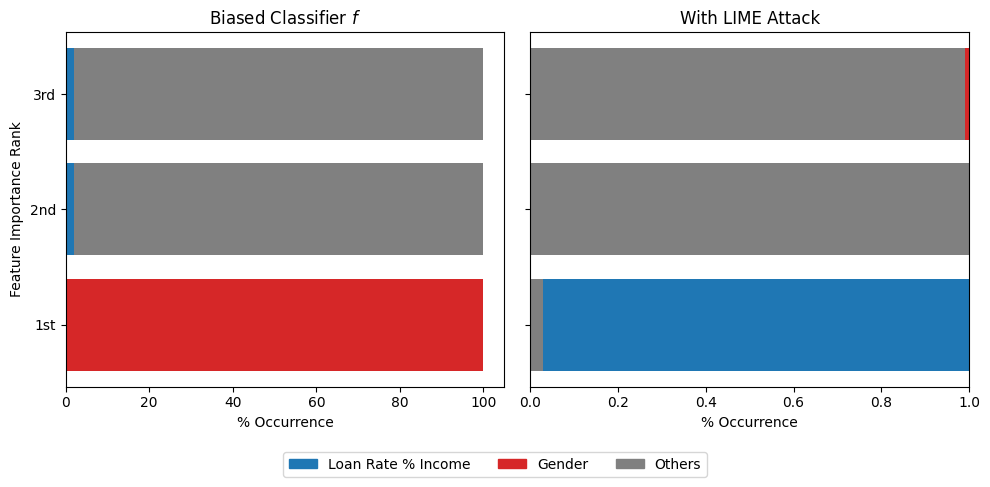

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for one unrelated feature
lime_one_unrelated = {
    1: [('HasCoapplicant', 0.01), ('LoanRateAsPercentOfIncome', 0.97), ('NoCurrentLoan', 0.01), ('Unemployed', 0.01)],
    2: [('CheckingAccountBalance_geq_200', 0.09), ('CriticalAccountOrLoansElsewhere', 0.04), ('ForeignWorker', 0.12), ('HasCoapplicant', 0.18), ('HasGuarantor', 0.11), ('MissedPayments', 0.09), ('NoCurrentLoan', 0.14), ('OtherLoansAtBank', 0.04), ('OwnsHouse', 0.01), ('RentsHouse', 0.03), ('SavingsAccountBalance_geq_500', 0.02), ('Unemployed', 0.09), ('YearsAtCurrentJob_geq_4', 0.01), ('YearsAtCurrentJob_lt_1', 0.03)],
    3: [('CheckingAccountBalance_geq_0', 0.03), ('CheckingAccountBalance_geq_200', 0.08), ('ForeignWorker', 0.15), ('Gender', 0.01), ('HasCoapplicant', 0.08), ('HasGuarantor', 0.13), ('HasTelephone', 0.02), ('JobClassIsSkilled', 0.01), ('MissedPayments', 0.08), ('NoCurrentLoan', 0.09), ('OtherLoansAtBank', 0.05), ('OwnsHouse', 0.01), ('RentsHouse', 0.02), ('SavingsAccountBalance_geq_100', 0.01), ('SavingsAccountBalance_geq_500', 0.08), ('Single', 0.01), ('Unemployed', 0.1), ('YearsAtCurrentJob_geq_4', 0.01), ('YearsAtCurrentJob_lt_1', 0.03)]
}


# Convert data to DataFrame and group certain features, rename "race" to "African-American"
def convert_to_df(data, label):
    rank_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
    rows = []
    for rank, features in data.items():
        other_pct = 0
        for feature, pct in features:
            if feature not in ['LoanRateAsPercentOfIncome', 'Gender']:
                other_pct += pct
            else:
                rows.append((rank_mapping[rank], feature, pct, label))
        rows.append((rank_mapping[rank], 'All others', other_pct, label))
    return pd.DataFrame(rows, columns=['Rank', 'Feature', 'Pct', 'Label'])


# Data for one and two unrelated features
df_one_unrelated = convert_to_df(lime_one_unrelated, 'With LIME Attack')


# Define color palette
palette = {
    'Gender': '#d62728',  # red
    'LoanRateAsPercentOfIncome': '#1f77b4',  # blue
    'All others': 'gray'
}

# Ensure data completeness for stacking
def complete_data(df):
    ranks = ['1st', '2nd', '3rd']
    features = df['Feature'].unique()
    complete_df = pd.DataFrame()

    for rank in ranks:
        for feature in features:
            # Check if there is any row that matches both the rank and the feature
            if ((df['Rank'] == rank) & (df['Feature'] == feature)).any():
                temp_df = df[(df['Rank'] == rank) & (df['Feature'] == feature)]
            else:
                # If no match is found, create a new row with 0 percent
                temp_df = pd.DataFrame({'Rank': [rank], 'Feature': [feature], 'Pct': [0], 'Label': [df['Label'].iloc[0]]})
            complete_df = pd.concat([complete_df, temp_df], ignore_index=True)
    return complete_df


# Create a stacked bar plot
def plot_stacked_bar(data, ax, title):
    data = complete_data(data)  # Ensure data is complete
    data = data.sort_values(by=['Rank', 'Feature'])  # Sort data to ensure consistent plotting

    ranks = ['1st', '2nd', '3rd']
    for rank in ranks:
        bottom = 0
        rank_data = data[data['Rank'] == rank]
        for _, row in rank_data.iterrows():
            ax.barh(rank, row['Pct'], left=bottom, color=palette[row['Feature']], label=row['Feature'])
            bottom += row['Pct']

    ax.set_title(title)
    ax.set_xlabel('% Occurrence')
    ax.set_ylabel('')

# Generate plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Biased Classifier f
axes[0].barh(['1st', '2nd', '3rd'], [100, 0, 0], color=palette['Gender'], label='Gender')
axes[0].barh(['1st', '2nd', '3rd'], [0, 100, 100], color=palette['All others'], label='All others')
axes[0].barh(['1st', '2nd', '3rd'], [0, 2, 2], color=palette['LoanRateAsPercentOfIncome'], label='LoanRateAsPercentOfIncome')
axes[0].set_title('Biased Classifier $f$')
axes[0].set_xlabel('% Occurrence')
axes[0].set_ylabel('Feature Importance Rank')

# Assuming df_one_unrelated and df_two_unrelated are defined as before
df = pd.concat([df_one_unrelated])  # assuming they are already defined

# Attack 1 Feature
plot_stacked_bar(df[df['Label'] == 'With LIME Attack'], axes[1], 'With LIME Attack')

# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(color=palette['LoanRateAsPercentOfIncome'], label='Loan Rate % Income'),
                  Patch(color=palette['Gender'], label='Gender'),
                  Patch(color=palette['All others'], label='Others')]

# Adjust legend to show only once with the specified order
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('images/FI_german_lime.png', dpi=300)
plt.show()

## COMPAS - GLIME

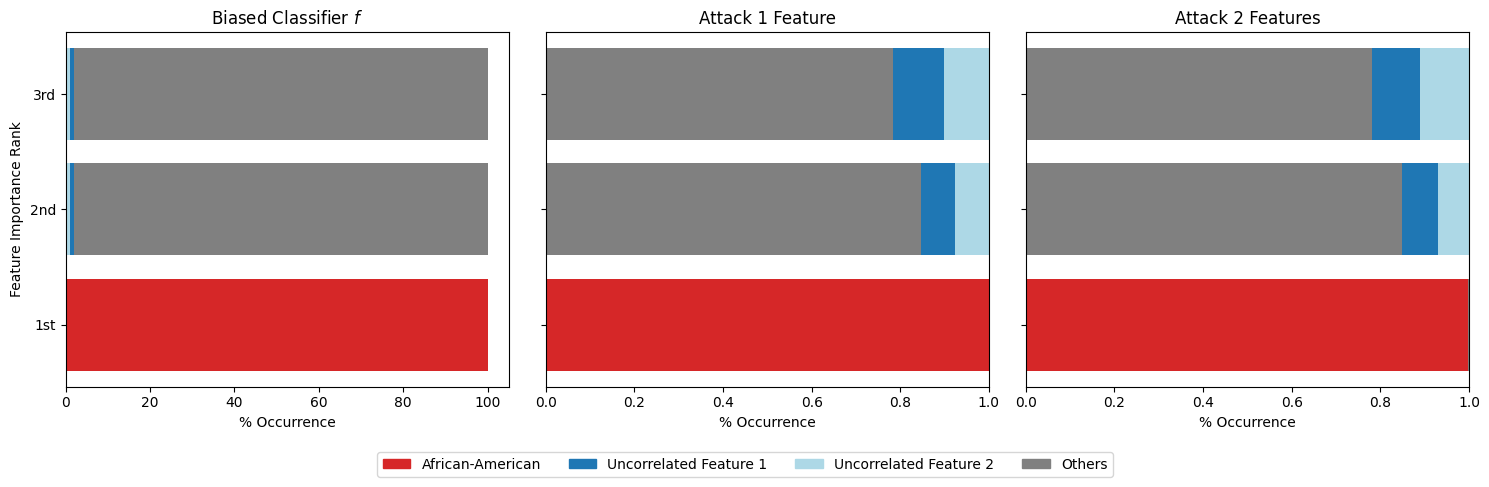

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for one unrelated feature
lime_one_unrelated = {1: [('race', 1.0)], 2: [('age', 0.021035598705501618), ('c_charge_degree_F', 0.08090614886731391), ('c_charge_degree_M', 0.07928802588996764), ('length_of_stay', 0.22491909385113268), ('priors_count', 0.07605177993527508), ('sex_Female', 0.13754045307443366), ('sex_Male', 0.15048543689320387), ('two_year_recid', 0.07605177993527508), ('unrelated_column_one', 0.07766990291262135), ('unrelated_column_two', 0.07605177993527508)], 3: [('age', 0.024271844660194174), ('c_charge_degree_F', 0.09546925566343042), ('c_charge_degree_M', 0.10355987055016182), ('length_of_stay', 0.1488673139158576), ('priors_count', 0.09061488673139159), ('sex_Female', 0.11812297734627832), ('sex_Male', 0.11812297734627832), ('two_year_recid', 0.08414239482200647), ('unrelated_column_one', 0.11650485436893204), ('unrelated_column_two', 0.10032362459546926)]}

# Data for two unrelated features
lime_two_unrelated = {1: [('age', 0.0016181229773462784), ('race', 0.9983818770226537)], 2: [('age', 0.014563106796116505), ('c_charge_degree_F', 0.08090614886731391), ('c_charge_degree_M', 0.08090614886731391), ('length_of_stay', 0.26537216828478966), ('priors_count', 0.059870550161812294), ('race', 0.0016181229773462784), ('sex_Female', 0.13915857605177995), ('sex_Male', 0.13915857605177995), ('two_year_recid', 0.06796116504854369), ('unrelated_column_one', 0.08090614886731391), ('unrelated_column_two', 0.06957928802588997)], 3: [('age', 0.038834951456310676), ('c_charge_degree_F', 0.10517799352750809), ('c_charge_degree_M', 0.10355987055016182), ('length_of_stay', 0.1262135922330097), ('priors_count', 0.0889967637540453), ('sex_Female', 0.12135922330097088), ('sex_Male', 0.1262135922330097), ('two_year_recid', 0.07119741100323625), ('unrelated_column_one', 0.10679611650485436), ('unrelated_column_two', 0.11165048543689321)]}


# Convert data to DataFrame and group certain features, rename "race" to "African-American"
def convert_to_df(data, label):
    rank_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
    rows = []
    for rank, features in data.items():
        other_pct = 0
        for feature, pct in features:
            if feature == 'race':
                feature = 'African-American'  # Rename 'race' to 'African-American'
            if feature not in ['African-American', 'unrelated_column_one', 'unrelated_column_two']:
                other_pct += pct
            else:
                rows.append((rank_mapping[rank], feature, pct, label))
        rows.append((rank_mapping[rank], 'All others', other_pct, label))
    return pd.DataFrame(rows, columns=['Rank', 'Feature', 'Pct', 'Label'])


# Data for one and two unrelated features
df_one_unrelated = convert_to_df(lime_one_unrelated, 'Attack 1 Feature')
df_two_unrelated = convert_to_df(lime_two_unrelated, 'Attack 2 Features')


# Define color palette
palette = {
    'African-American': '#d62728',  # red
    'unrelated_column_one': '#1f77b4',  # blue
    'unrelated_column_two': '#add8e6',  # light blue
    'All others': 'gray'
}

# Ensure data completeness for stacking
def complete_data(df):
    ranks = ['1st', '2nd', '3rd']
    features = df['Feature'].unique()
    complete_df = pd.DataFrame()

    for rank in ranks:
        for feature in features:
            # Check if there is any row that matches both the rank and the feature
            if ((df['Rank'] == rank) & (df['Feature'] == feature)).any():
                temp_df = df[(df['Rank'] == rank) & (df['Feature'] == feature)]
            else:
                # If no match is found, create a new row with 0 percent
                temp_df = pd.DataFrame({'Rank': [rank], 'Feature': [feature], 'Pct': [0], 'Label': [df['Label'].iloc[0]]})
            complete_df = pd.concat([complete_df, temp_df], ignore_index=True)
    return complete_df


# Create a stacked bar plot
def plot_stacked_bar(data, ax, title):
    data = complete_data(data)  # Ensure data is complete
    data = data.sort_values(by=['Rank', 'Feature'])  # Sort data to ensure consistent plotting

    ranks = ['1st', '2nd', '3rd']
    for rank in ranks:
        bottom = 0
        rank_data = data[data['Rank'] == rank]
        for _, row in rank_data.iterrows():
            ax.barh(rank, row['Pct'], left=bottom, color=palette[row['Feature']], label=row['Feature'])
            bottom += row['Pct']

    ax.set_title(title)
    ax.set_xlabel('% Occurrence')
    ax.set_ylabel('')

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Biased Classifier f
axes[0].barh(['1st', '2nd', '3rd'], [100, 0, 0], color=palette['African-American'], label='African-American')
axes[0].barh(['1st', '2nd', '3rd'], [0, 100, 100], color=palette['All others'], label='All others')
axes[0].barh(['1st', '2nd', '3rd'], [0, 2, 2], color=palette['unrelated_column_one'], label='unrelated_column_one')
axes[0].barh(['1st', '2nd', '3rd'], [0, 1, 1], color=palette['unrelated_column_two'], label='unrelated_column_two')
axes[0].set_title('Biased Classifier $f$')
axes[0].set_xlabel('% Occurrence')
axes[0].set_ylabel('Feature Importance Rank')

# Assuming df_one_unrelated and df_two_unrelated are defined as before
df = pd.concat([df_one_unrelated, df_two_unrelated])  # assuming they are already defined

# Attack 1 Feature
plot_stacked_bar(df[df['Label'] == 'Attack 1 Feature'], axes[1], 'Attack 1 Feature')

# Attack 2 Features
plot_stacked_bar(df[df['Label'] == 'Attack 2 Features'], axes[2], 'Attack 2 Features')


# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(color=palette['African-American'], label='African-American'),
                  Patch(color=palette['unrelated_column_one'], label='Uncorrelated Feature 1'),
                  Patch(color=palette['unrelated_column_two'], label='Uncorrelated Feature 2'),
                  Patch(color=palette['All others'], label='Others')]

# Adjust legend to show only once with the specified order
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('images/FI_compas_glime.png', dpi=300)
plt.show()


## CC - GLIME

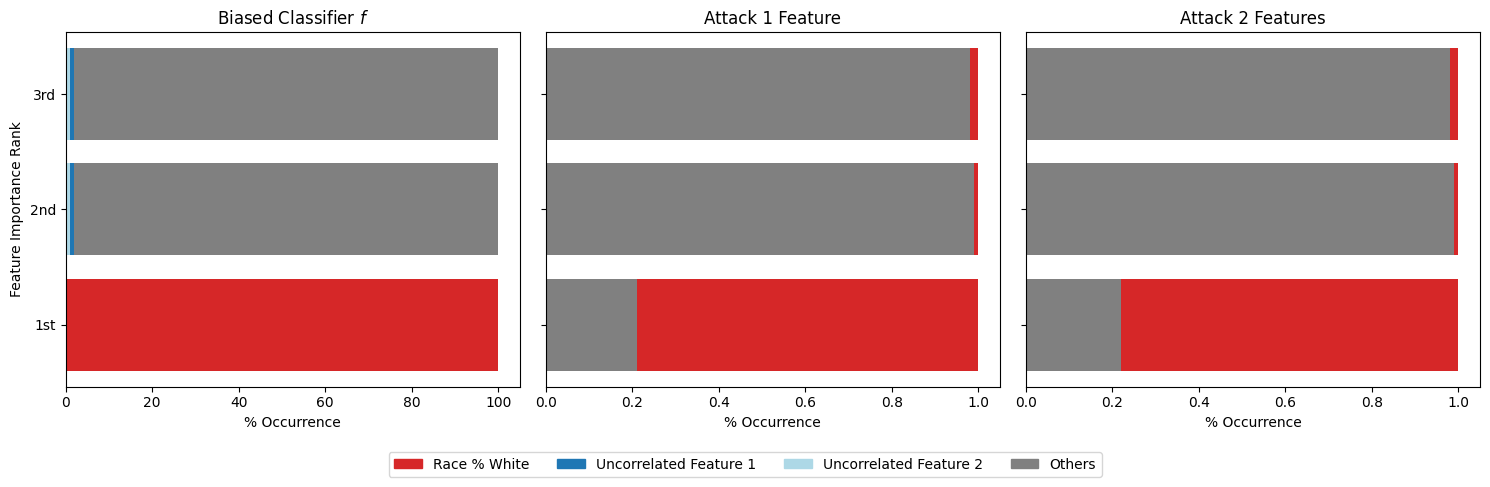

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for one unrelated feature
lime_one_unrelated = {1: [('PctIlleg numeric', 0.005), ('PctKids2Par numeric', 0.055), ('PctLargHouseOccup numeric', 0.005), ('PctPersOwnOccup numeric', 0.01), ('PctRecImmig10 numeric', 0.005), ('PersPerFam numeric', 0.01), ('PersPerRentOccHous numeric', 0.005), ('indianPerCap numeric', 0.005), ('perCapInc numeric', 0.04), ('racePctWhite numeric', 0.79), ('racepctblack numeric', 0.005), ('whitePerCap numeric', 0.065)], 2: [('FemalePctDiv numeric', 0.01), ('MedOwnCostPctInc numeric', 0.02), ('NumIlleg numeric', 0.01), ('OwnOccMedVal numeric', 0.01), ('PctFam2Par numeric', 0.025), ('PctHousOwnOcc numeric', 0.03), ('PctIlleg numeric', 0.02), ('PctKids2Par numeric', 0.08), ('PctLargHouseFam numeric', 0.01), ('PctLargHouseOccup numeric', 0.01), ('PctPersDenseHous numeric', 0.1), ('PctPersOwnOccup numeric', 0.01), ('PctRecImmig10 numeric', 0.01), ('PctRecImmig5 numeric', 0.04), ('PctRecImmig8 numeric', 0.005), ('PersPerFam numeric', 0.01), ('PersPerOccupHous numeric', 0.01), ('PersPerOwnOccHous numeric', 0.005), ('PersPerRentOccHous numeric', 0.005), ('RentHighQ numeric', 0.005), ('TotalPctDiv numeric', 0.055), ('medFamInc numeric', 0.055), ('medIncome numeric', 0.005), ('pctWInvInc numeric', 0.005), ('perCapInc numeric', 0.22), ('population numeric', 0.01), ('racePctHisp numeric', 0.005), ('racePctWhite numeric', 0.01), ('racepctblack numeric', 0.1), ('whitePerCap numeric', 0.11)], 3: [('FemalePctDiv numeric', 0.015), ('MalePctDivorce numeric', 0.005), ('MedOwnCostPctInc numeric', 0.015), ('NumIlleg numeric', 0.005), ('OwnOccMedVal numeric', 0.01), ('PctBSorMore numeric', 0.005), ('PctFam2Par numeric', 0.095), ('PctForeignBorn numeric', 0.005), ('PctHousOwnOcc numeric', 0.03), ('PctIlleg numeric', 0.015), ('PctKids2Par numeric', 0.015), ('PctLargHouseFam numeric', 0.01), ('PctLargHouseOccup numeric', 0.01), ('PctPersDenseHous numeric', 0.03), ('PctPersOwnOccup numeric', 0.085), ('PctRecImmig10 numeric', 0.09), ('PctRecImmig5 numeric', 0.025), ('PctSpeakEnglOnly numeric', 0.005), ('PersPerFam numeric', 0.01), ('PersPerOccupHous numeric', 0.015), ('PersPerOwnOccHous numeric', 0.015), ('RentHighQ numeric', 0.045), ('TotalPctDiv numeric', 0.03), ('agePct16t24 numeric', 0.01), ('medFamInc numeric', 0.075), ('perCapInc numeric', 0.11), ('population numeric', 0.01), ('racePctHisp numeric', 0.005), ('racePctWhite numeric', 0.02), ('racepctblack numeric', 0.03), ('whitePerCap numeric', 0.155)]}

# Data for two unrelated features
lime_two_unrelated = {1: [('PctFam2Par numeric', 0.005), ('PctIlleg numeric', 0.005), ('PctKids2Par numeric', 0.06), ('PctLargHouseOccup numeric', 0.005), ('PctPersOwnOccup numeric', 0.015), ('PctRecImmig10 numeric', 0.005), ('PersPerFam numeric', 0.005), ('PersPerRentOccHous numeric', 0.005), ('indianPerCap numeric', 0.005), ('perCapInc numeric', 0.05), ('racePctWhite numeric', 0.78), ('racepctblack numeric', 0.005), ('whitePerCap numeric', 0.055)], 2: [('MedOwnCostPctInc numeric', 0.015), ('NumIlleg numeric', 0.01), ('OwnOccMedVal numeric', 0.01), ('PctFam2Par numeric', 0.025), ('PctHousOwnOcc numeric', 0.04), ('PctIlleg numeric', 0.025), ('PctKids2Par numeric', 0.075), ('PctLargHouseFam numeric', 0.01), ('PctLargHouseOccup numeric', 0.01), ('PctPersDenseHous numeric', 0.085), ('PctPersOwnOccup numeric', 0.015), ('PctRecImmig10 numeric', 0.01), ('PctRecImmig5 numeric', 0.03), ('PersPerFam numeric', 0.01), ('PersPerOccupHous numeric', 0.01), ('PersPerOwnOccHous numeric', 0.01), ('PersPerRentOccHous numeric', 0.005), ('RentHighQ numeric', 0.005), ('TotalPctDiv numeric', 0.055), ('medFamInc numeric', 0.055), ('pctWInvInc numeric', 0.005), ('perCapInc numeric', 0.21), ('population numeric', 0.015), ('racePctHisp numeric', 0.005), ('racePctWhite numeric', 0.01), ('racepctblack numeric', 0.105), ('whitePerCap numeric', 0.14)], 3: [('FemalePctDiv numeric', 0.02), ('MalePctDivorce numeric', 0.005), ('MedOwnCostPctInc numeric', 0.02), ('NumIlleg numeric', 0.005), ('NumImmig numeric', 0.005), ('OwnOccMedVal numeric', 0.01), ('PctBSorMore numeric', 0.005), ('PctFam2Par numeric', 0.08), ('PctForeignBorn numeric', 0.005), ('PctHousOwnOcc numeric', 0.035), ('PctIlleg numeric', 0.015), ('PctKids2Par numeric', 0.01), ('PctLargHouseFam numeric', 0.005), ('PctLargHouseOccup numeric', 0.01), ('PctPersDenseHous numeric', 0.015), ('PctPersOwnOccup numeric', 0.08), ('PctRecImmig10 numeric', 0.095), ('PctRecImmig5 numeric', 0.03), ('PctRecImmig8 numeric', 0.005), ('PersPerFam numeric', 0.015), ('PersPerOccupHous numeric', 0.02), ('PersPerOwnOccHous numeric', 0.005), ('RentHighQ numeric', 0.035), ('TotalPctDiv numeric', 0.05), ('agePct16t24 numeric', 0.01), ('medFamInc numeric', 0.07), ('medIncome numeric', 0.005), ('perCapInc numeric', 0.125), ('population numeric', 0.005), ('racePctHisp numeric', 0.005), ('racePctWhite numeric', 0.02), ('racepctblack numeric', 0.025), ('whitePerCap numeric', 0.155)]}

# Convert data to DataFrame and group certain features, rename "race" to "African-American"
def convert_to_df(data, label):
    rank_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
    rows = []
    for rank, features in data.items():
        other_pct = 0
        for feature, pct in features:
            if feature not in ['racePctWhite numeric', 'unrelated_column_one', 'unrelated_column_two']:
                other_pct += pct
            else:
                rows.append((rank_mapping[rank], feature, pct, label))
        rows.append((rank_mapping[rank], 'All others', other_pct, label))
    return pd.DataFrame(rows, columns=['Rank', 'Feature', 'Pct', 'Label'])


# Data for one and two unrelated features
df_one_unrelated = convert_to_df(lime_one_unrelated, 'Attack 1 Feature')
df_two_unrelated = convert_to_df(lime_two_unrelated, 'Attack 2 Features')


# Define color palette
palette = {
    'racePctWhite numeric': '#d62728',  # red
    'unrelated_column_one': '#1f77b4',  # blue
    'unrelated_column_two': '#add8e6',  # light blue
    'All others': 'gray'
}

# Ensure data completeness for stacking
def complete_data(df):
    ranks = ['1st', '2nd', '3rd']
    features = df['Feature'].unique()
    complete_df = pd.DataFrame()

    for rank in ranks:
        for feature in features:
            # Check if there is any row that matches both the rank and the feature
            if ((df['Rank'] == rank) & (df['Feature'] == feature)).any():
                temp_df = df[(df['Rank'] == rank) & (df['Feature'] == feature)]
            else:
                # If no match is found, create a new row with 0 percent
                temp_df = pd.DataFrame({'Rank': [rank], 'Feature': [feature], 'Pct': [0], 'Label': [df['Label'].iloc[0]]})
            complete_df = pd.concat([complete_df, temp_df], ignore_index=True)
    return complete_df


# Create a stacked bar plot
def plot_stacked_bar(data, ax, title):
    data = complete_data(data)  # Ensure data is complete
    data = data.sort_values(by=['Rank', 'Feature'])  # Sort data to ensure consistent plotting

    ranks = ['1st', '2nd', '3rd']
    for rank in ranks:
        bottom = 0
        rank_data = data[data['Rank'] == rank]
        for _, row in rank_data.iterrows():
            ax.barh(rank, row['Pct'], left=bottom, color=palette[row['Feature']], label=row['Feature'])
            bottom += row['Pct']

    ax.set_title(title)
    ax.set_xlabel('% Occurrence')
    ax.set_ylabel('')

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Biased Classifier f
axes[0].barh(['1st', '2nd', '3rd'], [100, 0, 0], color=palette['racePctWhite numeric'], label='racePctWhite numeric')
axes[0].barh(['1st', '2nd', '3rd'], [0, 100, 100], color=palette['All others'], label='All others')
axes[0].barh(['1st', '2nd', '3rd'], [0, 2, 2], color=palette['unrelated_column_one'], label='unrelated_column_one')
axes[0].barh(['1st', '2nd', '3rd'], [0, 1, 1], color=palette['unrelated_column_two'], label='unrelated_column_two')
axes[0].set_title('Biased Classifier $f$')
axes[0].set_xlabel('% Occurrence')
axes[0].set_ylabel('Feature Importance Rank')

# Assuming df_one_unrelated and df_two_unrelated are defined as before
df = pd.concat([df_one_unrelated, df_two_unrelated])  # assuming they are already defined

# Attack 1 Feature
plot_stacked_bar(df[df['Label'] == 'Attack 1 Feature'], axes[1], 'Attack 1 Feature')

# Attack 2 Features
plot_stacked_bar(df[df['Label'] == 'Attack 2 Features'], axes[2], 'Attack 2 Features')


# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(color=palette['racePctWhite numeric'], label='Race % White'),
                  Patch(color=palette['unrelated_column_one'], label='Uncorrelated Feature 1'),
                  Patch(color=palette['unrelated_column_two'], label='Uncorrelated Feature 2'),
                  Patch(color=palette['All others'], label='Others')]

# Adjust legend to show only once with the specified order
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('images/FI_cc_glime.png', dpi=300)
plt.show()

## German - GLIME

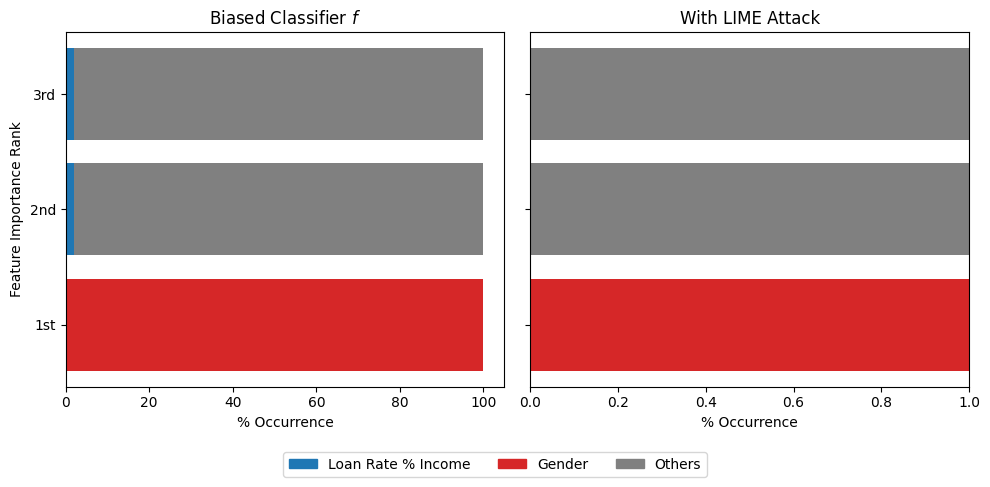

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for one unrelated feature
lime_one_unrelated = {1: [('Gender', 1.0)], 2: [('CheckingAccountBalance_geq_0', 0.02), ('CheckingAccountBalance_geq_200', 0.08), ('CriticalAccountOrLoansElsewhere', 0.01), ('ForeignWorker', 0.24), ('HasCoapplicant', 0.21), ('HasGuarantor', 0.05), ('MissedPayments', 0.01), ('NoCurrentLoan', 0.09), ('OtherLoansAtBank', 0.03), ('OwnsHouse', 0.01), ('RentsHouse', 0.02), ('SavingsAccountBalance_geq_100', 0.01), ('SavingsAccountBalance_geq_500', 0.03), ('Single', 0.01), ('Unemployed', 0.12), ('YearsAtCurrentJob_geq_4', 0.02), ('YearsAtCurrentJob_lt_1', 0.04)], 3: [('CheckingAccountBalance_geq_0', 0.01), ('CheckingAccountBalance_geq_200', 0.19), ('CriticalAccountOrLoansElsewhere', 0.01), ('ForeignWorker', 0.08), ('HasCoapplicant', 0.08), ('HasGuarantor', 0.1), ('HasTelephone', 0.03), ('JobClassIsSkilled', 0.01), ('MissedPayments', 0.06), ('NoCurrentLoan', 0.16), ('OtherLoansAtBank', 0.03), ('OwnsHouse', 0.01), ('RentsHouse', 0.02), ('SavingsAccountBalance_geq_100', 0.02), ('SavingsAccountBalance_geq_500', 0.06), ('Single', 0.01), ('Unemployed', 0.09), ('YearsAtCurrentJob_geq_4', 0.02), ('YearsAtCurrentJob_lt_1', 0.01)]}


# Convert data to DataFrame and group certain features, rename "race" to "African-American"
def convert_to_df(data, label):
    rank_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
    rows = []
    for rank, features in data.items():
        other_pct = 0
        for feature, pct in features:
            if feature not in ['LoanRateAsPercentOfIncome', 'Gender']:
                other_pct += pct
            else:
                rows.append((rank_mapping[rank], feature, pct, label))
        rows.append((rank_mapping[rank], 'All others', other_pct, label))
    return pd.DataFrame(rows, columns=['Rank', 'Feature', 'Pct', 'Label'])


# Data for one and two unrelated features
df_one_unrelated = convert_to_df(lime_one_unrelated, 'With LIME Attack')


# Define color palette
palette = {
    'Gender': '#d62728',  # red
    'LoanRateAsPercentOfIncome': '#1f77b4',  # blue
    'All others': 'gray'
}

# Ensure data completeness for stacking
def complete_data(df):
    ranks = ['1st', '2nd', '3rd']
    features = df['Feature'].unique()
    complete_df = pd.DataFrame()

    for rank in ranks:
        for feature in features:
            # Check if there is any row that matches both the rank and the feature
            if ((df['Rank'] == rank) & (df['Feature'] == feature)).any():
                temp_df = df[(df['Rank'] == rank) & (df['Feature'] == feature)]
            else:
                # If no match is found, create a new row with 0 percent
                temp_df = pd.DataFrame({'Rank': [rank], 'Feature': [feature], 'Pct': [0], 'Label': [df['Label'].iloc[0]]})
            complete_df = pd.concat([complete_df, temp_df], ignore_index=True)
    return complete_df


# Create a stacked bar plot
def plot_stacked_bar(data, ax, title):
    data = complete_data(data)  # Ensure data is complete
    data = data.sort_values(by=['Rank', 'Feature'])  # Sort data to ensure consistent plotting

    ranks = ['1st', '2nd', '3rd']
    for rank in ranks:
        bottom = 0
        rank_data = data[data['Rank'] == rank]
        for _, row in rank_data.iterrows():
            ax.barh(rank, row['Pct'], left=bottom, color=palette[row['Feature']], label=row['Feature'])
            bottom += row['Pct']

    ax.set_title(title)
    ax.set_xlabel('% Occurrence')
    ax.set_ylabel('')

# Generate plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Biased Classifier f
axes[0].barh(['1st', '2nd', '3rd'], [100, 0, 0], color=palette['Gender'], label='Gender')
axes[0].barh(['1st', '2nd', '3rd'], [0, 100, 100], color=palette['All others'], label='All others')
axes[0].barh(['1st', '2nd', '3rd'], [0, 2, 2], color=palette['LoanRateAsPercentOfIncome'], label='LoanRateAsPercentOfIncome')
axes[0].set_title('Biased Classifier $f$')
axes[0].set_xlabel('% Occurrence')
axes[0].set_ylabel('Feature Importance Rank')

# Assuming df_one_unrelated and df_two_unrelated are defined as before
df = pd.concat([df_one_unrelated])  # assuming they are already defined

# Attack 1 Feature
plot_stacked_bar(df[df['Label'] == 'With LIME Attack'], axes[1], 'With LIME Attack')

# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(color=palette['LoanRateAsPercentOfIncome'], label='Loan Rate % Income'),
                  Patch(color=palette['Gender'], label='Gender'),
                  Patch(color=palette['All others'], label='Others')]

# Adjust legend to show only once with the specified order
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('images/FI_german_glime.png', dpi=300)
plt.show()